In [14]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio, display
import cmath
#import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
# cqt values
#FFT_BINS = 768 # cqt value, function of items below
FFT_BINS = 513 # stft value
HOP_LENGTH = 256

BINS_PER_OCTAVE = 12 * 8
FMIN = librosa.note_to_hz('C1')
OCTAVES = 8

# stft values
N_FFT = 1024 # 512 recommended for speech, music typically 2048

# Idea here is that we operate on magnitude, and will just use phase from the original noisy sample

# Original FFT is from noisy file, and used to get phase information since we only train on magnitude
def rebuild_fft(output, original_fft):
    vphase = np.vectorize(cmath.phase)
    o_phase = vphase(original_fft)
    mag = output.T
    # This is a different way of getting the same result
    #o_mag = abs(original_fft)
    #scale = mag/o_mag
    #return scale * original_fft
    vrect = np.vectorize(cmath.rect)
    #null_phase = np.zeros(o_phase.shape)
    return vrect(mag, o_phase)
    
def get_ft(wav):
    #c = librosa.cqt(wav, hop_length=HOP_LENGTH, fmin=FMIN, n_bins=OCTAVES*BINS_PER_OCTAVE, bins_per_octave=BINS_PER_OCTAVE)
    c = librosa.stft(wav, hop_length=HOP_LENGTH, n_fft=N_FFT)
    return c

def inv_ft(ft):
    #return librosa.icqt(ft, hop_length=HOP_LENGTH, bins_per_octave=BINS_PER_OCTAVE)
    return librosa.istft(ft, hop_length=HOP_LENGTH)
    
# Sample output is (samples, bins) all converted to magnitude
def get_samples(file):
    wav, rate = librosa.core.load(file)
    samples = abs(get_ft(wav).T) # organized as bins, frames so we need to transpose them to frames, bins
    return samples

# Only need this for testing at this point?  Could still make it a 'top' type shared function
def clip_frames(file):
    samples = get_samples(file)
    frames = np.empty((samples.shape[0], WINDOW_SIZE, FFT_BINS, 1))
    half_win = WINDOW_SIZE//2
    padded_samples = np.concatenate([np.zeros((half_win, FFT_BINS)), samples, np.zeros((half_win, FFT_BINS))])
    for i in range(0, samples.shape[0]-1):
        frames[i,:,:,0] = padded_samples[i:i+WINDOW_SIZE,:]
    return frames


def display_fft(ft):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(ft), ref=np.max), y_axis='cqt_hz', x_axis='time')

def draw(wav):
    fft = get_ft(wav)
    display_fft(fft)
    return fft

(513, 340)


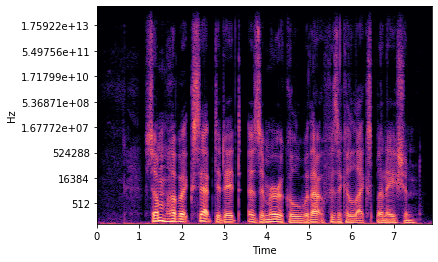

In [37]:
# Round trip test with no NN evaluation to test pipeline
# Have to get phase information from the noisy file to match what happens for real

file = "p232_013.wav"
clean_file = "Assets\\DataShareArchive\\Test\\Clean\\" + file
noisy_file = "Assets\\DataShareArchive\\Test\\Noisy\\" + file
wav, rate = librosa.core.load(test_file)
noisy_wav, rate = librosa.core.load(noisy_file)

noisy_ft = get_ft(noisy_wav)
clean_samples = get_samples(clean_file)

rt_ft = rebuild_fft(clean_samples, noisy_ft)

rt_wav = inv_ft(rt_ft)
print(rt_ft.shape)

display_fft(rt_ft)
Audio(rt_wav,rate=22050)

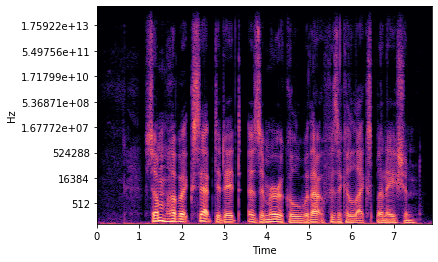

In [38]:
# Compare to clean
display_fft(get_ft(wav))
Audio(wav,rate=22050)

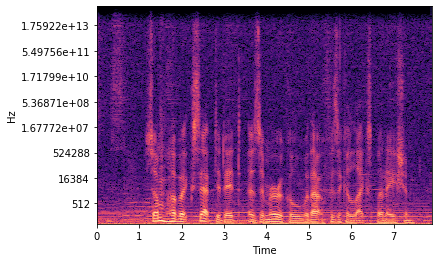

In [39]:
# Compare to noisy
display_fft(noisy_ft)
Audio(noisy_wav,rate=22050)

(768, 564)


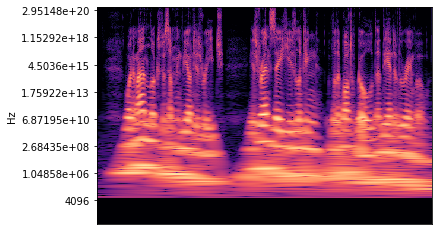

In [3]:
wav, rate = librosa.core.load("Assets\\DataShareArchive\\Test\\clean\\p232_011.wav")

#draw("p232_010.wav", "clean")

c_f = get_ft(wav)

def filter(cqt):
    cqt[0:BINS_PER_OCTAVE,:] = 0
    return cqt

c_f = filter(c_f)

librosa.display.specshow(librosa.amplitude_to_db(np.abs(c_f), ref=np.max), y_axis='cqt_hz')

print(c_f.shape)

rewav = inv_ft(c_f)

Audio(rewav, rate=rate)


In [4]:
Audio(wav, rate=rate)

noisy


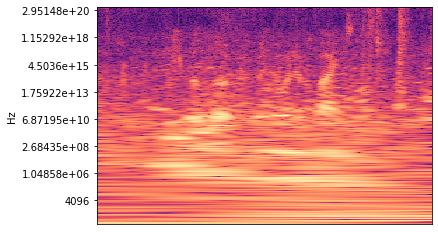

In [5]:
n_f = draw("p232_010.wav", "noisy")

(768, 564)


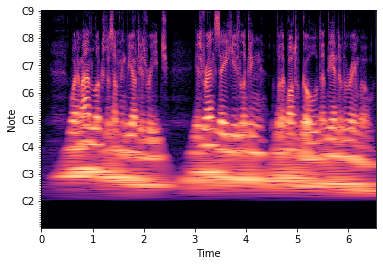

In [6]:
# CQT experiments

hop_length = 256
bins_per_octave = 12 * 8
fmin = librosa.note_to_hz('C1')
octaves = 8
C = librosa.cqt(wav, hop_length=hop_length, fmin=fmin, n_bins=octaves*bins_per_octave, bins_per_octave=bins_per_octave)
print(C.shape)

C[0:bins_per_octave,:] = 0
fade = bins_per_octave//2
for i in range(0,fade):
    C[bins_per_octave+i,:] = (i/fade) * C[bins_per_octave+i,:]

rewav = librosa.icqt(C, hop_length=hop_length, bins_per_octave=bins_per_octave)


librosa.display.specshow(librosa.amplitude_to_db(np.abs(C), ref=np.max), y_axis='cqt_note', x_axis='time', hop_length=hop_length, fmin=fmin,  bins_per_octave=bins_per_octave)


Audio(rewav, rate=rate)


In [27]:
# polar experiments
import cmath

n_f_m = abs(n_f)
c_f_m = abs(c_f)
vphase = np.vectorize(cmath.phase)
x = vphase(n_f)
print(x)

mag_ratio = c_f_m/n_f_m

re_f = n_f * mag_ratio

rewav = librosa.istft(re_f, hop_length=256)

Audio(rewav, rate=rate)

# this works for full complex numbers
#diff = n_f - c_f
#reclean = n_f - diff
#real_clean = c_f.real + 1j * c_f.imag


[[ 3.14159265e+00  3.14159265e+00  3.14159265e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.93247113e-17 -2.22143983e-01  6.26312975e-01 ... -6.19480375e-01
   2.37350034e+00 -3.12000531e+00]
 [ 0.00000000e+00  2.73088437e+00 -4.22332557e-01 ... -2.98761496e+00
  -5.06817173e-01  2.70924245e+00]
 ...
 [ 6.66177259e-15  3.13223559e+00 -2.25753568e+00 ...  2.61732576e+00
  -2.82378283e+00  3.18941012e-01]
 [-3.14159265e+00  1.55979296e+00 -7.24689288e-02 ... -7.23178393e-02
  -1.41321573e+00 -2.98216032e+00]
 [ 0.00000000e+00  0.00000000e+00  3.14159265e+00 ...  3.14159265e+00
   0.00000000e+00  0.00000000e+00]]


In [12]:
Audio(wav, rate=rate)


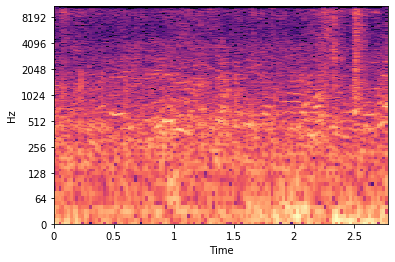

In [7]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(diff), ref=np.max), y_axis='log', x_axis='time')

In [38]:
round_trip = librosa.istft(real_clean)
Audio(round_trip, rate=rate)

In [29]:
round_trip = librosa.istft(X)
Audio(round_trip, rate=rate)